Craigslist Apartment Scrape | August 2017 | Author: https://github.com/beilmanmich

In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


# Craigslist Apartment Listing Scrape
I'm moving! As a result, I wanted to explore how I could automate regular searches of Craigslist, a popular user run website that lists apartments, sublets and house share options based on geographic pages.

In this notebook, I'll show you how to make a simple query on Craigslist using some nifty python modules. You can take advantage of all the structure data that exists on webpages to collect interesting datasets.

In [2]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. Here's a sample URL that is returned after manually typing in a search to Craigslist:

https://denver.craigslist.org/search/apa?hasPic=1&max_price=1200&availabilityMode=0&housing_type=1&housing_type=2&housing_type=6

As we can see, the above query string lists several search criteria "=", you can play around with the search options on the left navbar to decipher a pattern for the URL. Please note, this tutorial will only search listings with images (`hasPic=1`), this serves as a good proxy for listing quality (CL is prone to scams!).

![CL Params](./png/query_params.png)

So, as we can see, our search criteria is reflected in the URL:

Base URL (CL apartments in Denver) - `https://denver.craigslist.org/search/apa?`

* hasPic=1 (search only listings with an image)
* &max_price=1200 (to a max price of $1200)
* &availabilityMode=0 (default)
* &housing_type=1 (apartment)
* &housing_type=2 (condo)
* &housing_type=6 (house)

### Let's grab a single posting

So, we'll use this knowledge to send some custom URLs to Craigslist. We'll do this using the requests python module, which is really useful for querying websites.

In [3]:
import requests

In internet lingo, we're posting a *get* requests to the website, which simply says that we'd like to get some information from the Craigslist website. With requests, we can easily create a dictionary that specifies parameters in the URL:

In [4]:
url_base = 'http://denver.craigslist.org/search/apa'
# params = dict(bedrooms=1, housing_type=1, housing_type=2, housing_type=6)

#To pass multiple params create a custome Dict (http://docs.python-requests.org/en/master/user/quickstart/#passing-parameters-in-urls)
params = {'hasPic':'1','bedrooms': '1', 'housing_type': ['1','2','6']}
# params = dict(bedrooms=1, is_furnished=1)

rsp = requests.get(url_base, params=params)

In [5]:
# Note that requests automatically created the right URL:
print(rsp.url)

https://denver.craigslist.org/search/apa?bedrooms=1&housing_type=1&housing_type=2&housing_type=6&hasPic=1


Click the above link, make sure results appear, it should look the same as the screen shot!

In [7]:
# We can access the content of the response that Craigslist sent back here:
print(rsp.text[:500])

﻿<!DOCTYPE html>

<html class="no-js"><head>
    <title>denver apts/housing for rent  - craigslist</title>

    <meta name="description" content="denver apts/housing for rent  - craigslist">
    <meta http-equiv="X-UA-Compatible" content="IE=Edge"/>
    <link rel="canonical" href="https://denver.craigslist.org/search/apa">
    <link rel="alternate" type="application/rss+xml" href="https://denver.craigslist.org/search/apa?format=rss&amp;hasPic=1&amp;housing_type=1&amp;housing_type=2&amp;housing_t


**Wow, that's a lot of code.** Remember, websites serve HTML documents, and usually your browser will automatically render this into a nice webpage for you. Since we're doing this with python, we get back the raw text. This is really useful, but how can we possibly parse it all? For this, we'll turn to another great package, BeautifulSoup:

In [8]:
from bs4 import BeautifulSoup as bs4

# BS4 can quickly parse our text, make sure to tell it that you're giving html
html = bs4(rsp.text, 'html.parser')

# BS makes it easy to look through a document
print(html.prettify()[:1000])

﻿
<!DOCTYPE html>
<html class="no-js">
 <head>
  <title>
   denver apts/housing for rent  - craigslist
  </title>
  <meta content="denver apts/housing for rent  - craigslist" name="description">
   <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
   <link href="https://denver.craigslist.org/search/apa" rel="canonical">
    <link href="https://denver.craigslist.org/search/apa?format=rss&amp;hasPic=1&amp;housing_type=1&amp;housing_type=2&amp;housing_type=6&amp;min_bedrooms=1" rel="alternate" title="RSS feed for craigslist | denver apts/housing for rent  - craigslist " type="application/rss+xml">
     <link href="https://denver.craigslist.org/search/apa?s=120&amp;hasPic=1&amp;housing_type=1&amp;housing_type=2&amp;housing_type=6&amp;min_bedrooms=1" rel="next">
      <meta content="width=device-width,initial-scale=1" name="viewport">
       <link href="//www.craigslist.org/styles/cl.css?v=d76fe4376346bd1b2503fb10181051a7" media="all" rel="stylesheet" type="text/css">
        <link hre

**Beautiful soup** lets us quickly search through an HTML document. We can pull out whatever information we want.

Scanning through this text, we see a common structure repeated `<p class="result-info">`. This seems to be the container that has information for a single apartment.

In BeautifulSoup, we can quickly get all instances of this container:

Another way to inspect the website elements we want is to use Chrome's handy [DevTools](http://anti-code.com/devtools-cheatsheet/), which allows use to place our cursor over an element and see the corresponding HTML. As we can see in the below screenshot it becomes clear the class structure of CL's website, `p class="result-info"` indicates each resulting link (apartment listing), we can also further drill down to see we can grab other information by class, such as prize, size, BRs, etc.

For a better overview of this, please see [Greg Reda](http://www.gregreda.com/2013/03/03/web-scraping-101-with-python/).

![CL Class](./png/cl_class.png)

In [9]:
# find_all will pull entries that fit your search criteria.
# Note that we have to use brackets to define the `attrs` dictionary
# Because "class" is a special word in python, so we need to give a string.

# apts = html.find_all('p', attrs={'class': 'result-info'})

apts= html.find_all('p', class_='result-info')

print(len(apts))

120


Great, we've got the 120 results on page one of the CL search. Now let's take a look inside the values of a single apartment listing...

In [10]:
# We can see that there's a consistent structure to a listing.
# There is a 'time', a 'name', a 'housing' field with size/n_brs, etc.
this_appt = apts[30]
print(this_appt.prettify())

<p class="result-info">
 <span class="icon icon-star" role="button">
  <span class="screen-reader-text">
   favorite this post
  </span>
 </span>
 <time class="result-date" datetime="2017-08-09 07:40" title="Wed 09 Aug 07:40:14 AM">
  Aug  9
 </time>
 <a class="result-title hdrlnk" data-id="6214332910" href="/apa/d/4-br-3-bath-arvada/6214332910.html">
  4 Br, 3 Bath Arvada
 </a>
 <span class="result-meta">
  <span class="result-price">
   $2900
  </span>
  <span class="housing">
   4br -
                    4235ft
   <sup>
    2
   </sup>
   -
  </span>
  <span class="result-tags">
   pic
   <span class="maptag" data-pid="6214332910">
    map
   </span>
  </span>
  <span class="banish icon icon-trash" role="button">
   <span class="screen-reader-text">
    hide this posting
   </span>
  </span>
  <span aria-hidden="true" class="unbanish icon icon-trash red" role="button">
  </span>
  <a class="restore-link" href="#">
   <span class="restore-narrow-text">
    restore
   </span>
   <span

In [11]:
# So now we'll pull out a couple of things we might be interested in:
# It looks like "housing" contains size information. We'll pull that.
# Note that `findAll` returns a list, since there's only one entry in
# this HTML, we'll just pull the first item.
size = this_appt.findAll(attrs={'class': 'housing'})[0].text
print(size)


                    4br -
                    4235ft2 -
                


We can query split this into n_bedrooms and the size. However, note that sometimes one of these features might be missing. So we'll use an if statement to try and capture this variability:

In [12]:
def find_size_and_brs(size):

    split = size.split('-')
 
    if len(split) == 3:
        n_brs = split[0].replace('br', '')
        this_size = split[1].replace('ft2', '')
    elif 'br' in split[0]:
        # It's the n_bedrooms
        n_brs = split[0].replace('br', '')
        this_size = np.nan
    elif 'ft2' in split[0]:
        # It's the size
        this_size = split[0].replace('ft2', '')
        n_brs = np.nan
    return float(this_size), float(n_brs)

this_size, n_brs = find_size_and_brs(size)
this_time = this_appt.find('time')['datetime']
this_time = pd.to_datetime(this_time)
this_price = float(this_appt.find('span', {'class': 'result-price'}).text.strip('$'))
this_title = this_appt.find('a', attrs={'class': 'result-title hdrlnk'}).text

In [13]:
# Now we've got the n_bedrooms, size, price, and time of listing
print('\n'.join([str(i) for i in [this_size, n_brs, this_time, this_price, this_title]]))

4235.0
4.0
2017-08-09 07:40:00
2900.0
4 Br, 3 Bath Arvada


### Querying lots of postings
We've made some great headway understanding the query structure, and parsing the results for the key data points we want (size, time, price, title).

Now it is time to build a few more functions to parse many listings.

We'll define a few helper functions to handle edge cases and make sure that we don't get any errors.

In [14]:
def find_prices(results):
    prices = []
    for rw in results:
        price = rw.find('span', {'class': 'result-price'})
        if price is not None:
            price = float(price.text.strip('$'))
        else:
            price = np.nan
        prices.append(price)
    return prices

def find_times(results):
    times = []
    for rw in apts:
        if time is not None:
            time = time['datetime']
            time = pd.to_datetime(time)
        else:
            time = np.nan
        times.append(time)
    return times

Now we're ready to go. We'll loop through all of our locations, and pull a number of entries for each one. We'll use a pandas dataframe to store everything, because this will be useful for future analysis.

Note - Craigslist won't take kindly to you querying their server a bunch of times at once. Make sure not to pull too much data too quickly. Another option is to add a delay to each loop iteration. Otherwise your IP might get banned. **ALWAYS PLAY NICE WHEN SCRAPING**

In [15]:
# Now loop through all of CL and store the results
results = []  # We'll store the data here
# Careful with this...too many queries == your IP gets banned temporarily
# search_indices = np.arange(0, 2400, 100)

search_indices = np.arange(0, 300, 100)


for i in search_indices:
        url = 'http://denver.craigslist.org/search/apa'
        resp = requests.get(url, params={'bedrooms': 1, 's': i})
        txt = bs4(resp.text, 'html.parser')
        apts = txt.findAll(attrs={'class': "result-info"})
        
        # Find the size of all entries
        size_text = [rw.findAll(attrs={'class': 'housing'})[0].text
                     for rw in apts]
        sizes_brs = [find_size_and_brs(stxt) for stxt in size_text]

        sizes, n_brs = zip(*sizes_brs)  # This unzips into 2 vectors
     
        # Find the title and link
        title = [rw.find('a', attrs={'class': 'result-title hdrlnk'}).text
                      for rw in apts]
        links = [rw.find('a', attrs={'class': 'result-title hdrlnk'})['href']
                 for rw in apts]
        
        # Find the time
        time = [pd.to_datetime(rw.find('time')['datetime']) for rw in apts]
        price = find_prices(apts)
        
        # We'll create a dataframe to store all the data
        data = np.array([time, price, sizes, n_brs, title, links])
        col_names = ['time', 'price', 'size', 'brs', 'title', 'link']
        df = pd.DataFrame(data.T, columns=col_names)
        df = df.set_index('time')
        
        # Add the location variable to all entries
        #df['loc'] = loc
        results.append(df)
        
# Finally, concatenate all the results
results = pd.concat(results, axis=0)


In [16]:
# We'll make sure that the right columns are represented numerically:
results[['price', 'size', 'brs']] = results[['price', 'size', 'brs']].apply(pd.to_numeric)

In [17]:
results.head()

,price,size,brs,title,link
time,,,,,
2017-08-09 08:45:00,1803.0,1213.0,2.0,"Pool and Mountain Views in Select Homes, Court...",/apa/d/pool-and-mountain-views-in/6250253301.html
2017-08-09 08:44:00,1300.0,1075.0,2.0,2 bed/1 bath basement unit all utilities included,/apa/d/2-bed-1-bath-basement-unit/6256648800.html
2017-08-09 08:43:00,1099.0,665.0,1.0,"Renovated Clubhouse, New Stainless Steel Appli...",/apa/d/renovated-clubhouse-new/6216488683.html
2017-08-09 08:43:00,1795.0,1245.0,2.0,"Near Park Meadows Mall, Attached and Detached ...",/apa/d/near-park-meadows-mall/6256662656.html
2017-08-09 08:42:00,1990.0,NaN,3.0,"Location, Community, Quality Living. It Starts...",/apa/d/location-community-quality/6256662029.html


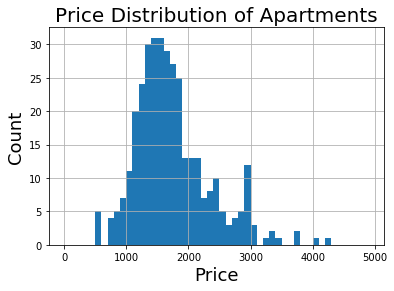

In [18]:
ax = results.hist('price', bins=np.arange(0, 5000, 100))[0, 0]
ax.set_title('Price Distribution of Apartments', fontsize=20)
ax.set_xlabel('Price', fontsize=18)
ax.set_ylabel('Count', fontsize=18)

In [19]:
# Finally, we can save this data to a CSV to play around with it later.
# We'll have to remove some annoying characters first:
import string
use_chars = string.ascii_letters +\
    ''.join([str(i) for i in range(10)]) +\
    ' /\.'
results['title'] = results['title'].apply(
    lambda a: ''.join([i for i in a if i in use_chars]))

results.to_csv('./data/craigslist_results.csv')

# RECAP

What did we just do?

* We defined the ability to query a website using a custom URL. This is isually the same in structure for a website, but the parameter names will be different.
* We sent a *get* request to Craigslist using the *requests* Python module.
* We parsed the response using *BeautifulSoup4*.
* We then looped through a bunch of apartment listings pulled some relevant data, and comibned it all into a cleaned and usable dataframe with Python's *pandas*.

I'll be condensing this walkthrough into a single scipt (.py) file. I'll also be brainstorming how to best capture this data from a time series perspective, hopefully running future analysis of Denver's rental market.

### BONUS - auto-emailing yourself with notifications

Yes, we can use this kind of process to make a bot that scrapes craigslist periodically. This is actually quite simple, as it basically involves pulling the top listings from craigslist, checking this against an "old" list, and detecting if there's anything new that has popped up since the last time you checked.

Here's a simple script that will get the job done. Once again, don't pull too much data at once, and don't query Craigslist too frequently, or you're gonna get banned.

In [20]:
# We'll use the gmail module (there really is a module for everything in python)
import gmail
import time
import email

In [ ]:
gm = gmail.GMail('username', 'password')
gm.connect()

Note: You'll need to reconfigure your Gmail account settings to allow access by less secure apps, or you'll need to setup an application-specific password rather than using your account-password. Similarly, you could create a dummy Gmail account.

Read more:

https://support.google.com/mail/?p=InvalidSecondFactor

https://security.google.com/settings/security/apppasswords

In [21]:
# Define our URL and a query we want to post
base_url = 'http://denver.craigslist.org'
url = base_url + '/search/roo?query=cap+hill'

# This will remove weird characters that people put in titles like ****!***!!!
use_chars = string.ascii_letters + ''.join([str(i) for i in range(10)]) + ' '

In [22]:
print url

http://denver.craigslist.org/search/roo?query=cap+hill


In [23]:
#SANDBOX

link_list = []  # We'll store the data here
link_list_send = []  # This is a list of links to be sent
send_list = []  # This is what will actually be sent in the email

resp = requests.get(url)
txt = bs4(resp.text, 'html.parser')
apts = txt.findAll(attrs={'class': "result-info"})

# We're just going to pull the title and link
for apt in apts:
    title = apt.find_all('a', attrs={'class': 'result-title hdrlnk'})[0]
    name = ''.join([i for i in title.text if i in use_chars])
    link = title.attrs['href']
    if link not in link_list and link not in link_list_send:
        print('Found new listing')
        link_list_send.append(link)
        send_list.append(str(name) + '  -  ' + base_url+link)

Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing
Found new listing


In [24]:
print link_list_send

[u'/roo/d/master-bedroom-available-in/6252891210.html', u'/roo/d/2-bedrooms-available-in-cap/6244607325.html', u'/roo/d/room-available-in-cap-hill/6224095429.html', u'/roo/d/spacious-bedroom-available-in/6249185296.html', u'/roo/d/private-bed-and-bath-in-cap/6237469650.html', u'/roo/d/1bdrm-in-renovated-cap-hill/6246738011.html', u'/roo/d/amazing-location-1bdrm-in/6229263531.html', u'/roo/d/roommate-uptown-cap-hill/6213416199.html', u'/roo/d/cap-hill-room-for-rent/6236887925.html', u'/roo/d/2-bed-2-bath-apartment-gov/6233941247.html', u'/roo/d/1-br-in-2br-apartment-in-cap/6207755782.html', u'/roo/d/room-in-2br-apt-cap-hill/6232993956.html', u'/roo/d/2-br-1-kit-1-fb-basement/6196193120.html', u'/roo/d/cap-hill-one-room-for-rent/6219832305.html', u'/roo/d/450-looking-for-roommate-in/6178076581.html', u'/roo/d/top-floor-mansion-lrg-room/6256550665.html', u'/roo/d/unique-butlers-quarters/6245897504.html', u'/roo/d/410-nice-room-available-in-2/6244692946.html', u'/roo/d/master-bedroom-for-r

In [26]:
print send_list

[u'Master bedroom available in awesome Cap Hill apartment  -  http://denver.craigslist.org/roo/d/master-bedroom-available-in/6252891210.html', u'2 bedrooms available in Cap Hill duplex  -  http://denver.craigslist.org/roo/d/2-bedrooms-available-in-cap/6244607325.html', u'Room Available in Cap Hill House 900  -  http://denver.craigslist.org/roo/d/room-available-in-cap-hill/6224095429.html', u'Spacious Bedroom Available in Cap Hill Home  -  http://denver.craigslist.org/roo/d/spacious-bedroom-available-in/6249185296.html', u'Private bed and bath in Cap Hill  available ASAP  -  http://denver.craigslist.org/roo/d/private-bed-and-bath-in-cap/6237469650.html', u'1bdrm in renovated Cap Hill condo avail Sept Amazing location  -  http://denver.craigslist.org/roo/d/1bdrm-in-renovated-cap-hill/6246738011.html', u'Amazing location 1bdrm in renovated Cap Hill condo avail Sept  -  http://denver.craigslist.org/roo/d/amazing-location-1bdrm-in/6229263531.html', u'Roommate uptowncap hill  -  http://denve

We're going to build a `while True:` loop (eventually the below code chunk is stored as an executable `.py` script). Read more about `while True:` logic [here](https://wiki.python.org/moin/WhileLoop)

We're just simply going to let this script run 24/7 in the background, thus allowing the cache to go uniterrupted and allowing the bot to perform it's simple job:

**Email whenever a new listing appears with our search criteria.**

Again, play nice with CL, your IP can get a ban if you scrape too much. You can alter the `sleep_amt` intervals and the end of the loop below to play nicely and stay on top of things.

In [ ]:
# Careful with this...too many queries == your IP gets banned temporarily

link_list = []  # We'll store the data here
link_list_send = []  # This is a list of links to be sent
send_list = []  # This is what will actually be sent in the email

# We're just going to pull the title and link
while True:
    resp = requests.get(url)
    txt = bs4(resp.text, 'html.parser')
    apts = txt.findAll(attrs={'class': "result-info"})
    # We're just going to pull the title and link
    for apt in apts:
        title = apt.find_all('a', attrs={'class': 'result-title hdrlnk'})[0]
        name = ''.join([i for i in title.text if i in use_chars])
        link = title.attrs['href']
        if link not in link_list and link not in link_list_send:
            print('Found new listing')
            link_list_send.append(link)
            send_list.append(str(name) + '  -  ' + base_url+link)

        # Flush the cache if we've found new entries
        if len(link_list_send) > 0:
            print('Sending mail!')
            msg = '\n'.join(send_list)
            m = email.message.Message()
            m.set_payload(msg)
            gm.send(m, ['beilman.mich@gmail.com'])
            link_list += link_list_send
            link_list_send = []
            send_list = []

        # Sleep a bit so CL doesn't ban us
        sleep_amt = np.random.randint(60, 120)
        time.sleep(sleep_amt)

And there you have it, a simple Craigslist Bot. [Automate the boring stuff](https://automatetheboringstuff.com/)

Note: the first time you run your Bot you may receive a lot of emails (if you have a broad search criteria like mine), let the Bot run for a few days to really see how well it does!